# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 23699 entries, 0 to 23698
,Data columns (total 22 columns):
, #   Column                Non-Null Count  Dtype  
,---  ------                --------------  -----  
, 0   total_images          23699 non-null  int64  
, 1   last_price            23699 non-null  float64
, 2   total_area            23699 non-null  float64
, 3   first_day_exposition  23699 non-null  object 
, 4   rooms                 23699 non-null  int64  
, 5   ceiling_height        14504 non-null  float64
, 6   floors_total          23613 non-null  float64
, 7   living_area           21796 non-null  float64
, 8   floor                 23699 non-null  int64  
, 9   is_apartment          2775 non-null   object 
, 10  studio                23699 non-null  bool   
, 11  open_plan             23699 non-null  bool   
, 12  kitchen_area          21421 non-null  float64
, 13  balcony               12180 non-null  float64
, 14  locality_name         23650 non-null  object 
, 15 

None

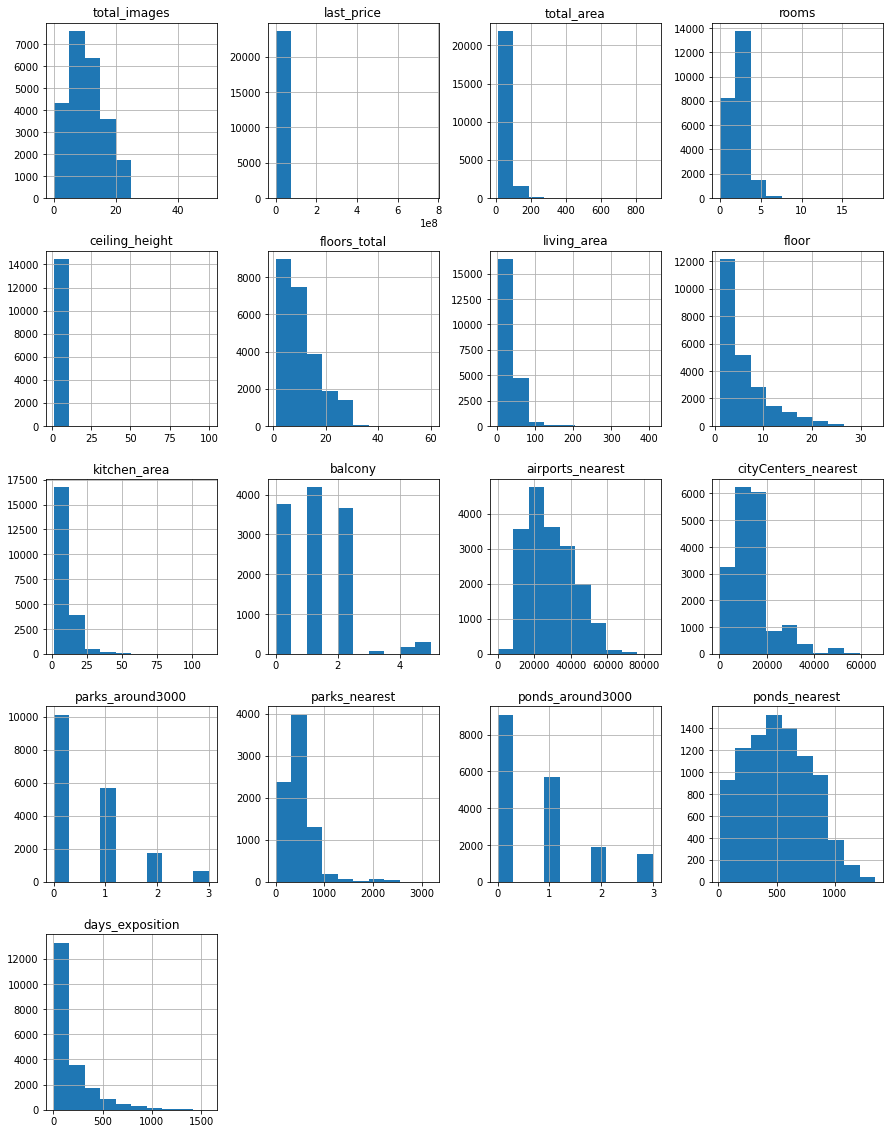

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
display(data.head())
display(data.info())
data.hist(figsize=(15, 20));

**Вывод:** 

Всего в изучаемых данных 23699 строк, присутствуют пропуски и некорректный тип данных, так же по гистограммам можно заметить, что в данных присутствуют аномальные значения

### Выполним предобработку данных

In [2]:
print(data.isna().sum())

total_images                0
,last_price                  0
,total_area                  0
,first_day_exposition        0
,rooms                       0
,ceiling_height           9195
,floors_total               86
,living_area              1903
,floor                       0
,is_apartment            20924
,studio                      0
,open_plan                   0
,kitchen_area             2278
,balcony                 11519
,locality_name              49
,airports_nearest         5542
,cityCenters_nearest      5519
,parks_around3000         5518
,parks_nearest           15620
,ponds_around3000         5518
,ponds_nearest           14589
,days_exposition          3181
,dtype: int64


В столбце цена на момент снятия с публикации установим тип данных integer - целочисленный

In [3]:
data['last_price']=data['last_price'].astype('int')

В столбце дата публикации считаю логичным установить числовой тип данных с помощью pd.to_datetime учитывая формат даты и времени

In [4]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Видим, что в столбце высота потолков пропущено 9195 значений, поэтому имеет смысл заменить значения NaN на медианное по столбцу "Высота потолков"

In [5]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

В столбцах количество этажей и жилая площадь пропущенные значения оставим без изменений, так как можно предположить, что в объявлениях намеренно не указали количество этажей и жилую площадь, привести данные к реальным значениям не представляется возможным.

Столбец является ли объект апартаментами необходимо заменит на булев тип, и присвоить пропущенным значениям значение False, так как скорее всего, пропущенные объекты не являются апартаментами

In [6]:
data['is_apartment']=data['is_apartment'].astype(bool)
data['is_apartment']=data['is_apartment'].fillna(False)

В столбце площадь кухни считаю необходимым заменить пропущенные значения на 0, так как скорее всего, значения не указали целенаправленно

In [7]:
data['kitchen_area']=data['kitchen_area'].fillna(0)

В столбце балконы считаю необходимым заменить пропущенные значения на 0, так как скорее всего, балконов нет

In [8]:
data['balcony']=data['balcony'].fillna(0)

В столбце населённый пункт избавимся от неявных дубликатов цепочкой методов .replace. Приведём к нижнему регистру, заменим ё на е и уберём лишние слова в названиях населённых пунктов

In [9]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [10]:
data['locality_name'] = data['locality_name'].astype(str).str.lower()
data['locality_name'] = (data['locality_name'].astype(str).str.replace('ё','е').replace(['поселок ','при железнодорожной станции ', 'платформа ', 'садоводческое некоммерческое товарищество ',
'садовое товарищество ', 'станции ', 'село ', 'пансионат ', 'городского типа ','деревня ', 'городской поселок '], '', regex=True))

In [11]:
data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'городской янино-1', 'парголово',
       'мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'кудрово', 'коммунар', 'колпино', 'красный бор', 'гатчина',
       'федоровское', 'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокс

В столбце расстояние до ближайшего аэропорта оставим пропуски без изменений так как скорее всего, аэропорт либо далеко либо отсутствует;

Аналогично поступим в столбцах: расстояние до центра города; расстояние до ближайшего парка; расстояние до ближайшего водоёма;

В столбцах количество парков и количество водоёмов в 3 км заменим пропущенные значения 0,так как скорее всего, значения пропущены ввиду отсутствия в  3 км парков и водоёмов; так же заменим тип данных на целочисленный


In [12]:
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['parks_around3000']=data['parks_around3000'].astype(int)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].astype(int)

В столбце сколько дней было размещено объявление от публикации до снятия присутствуют пропущенные значения, так как скорее всего, данные объекты не были проданы

**Вывод:** 

Таким образом, выполнили предобработку данных, уменьшили количество пропусков в данных, устранили дубликаты.

Основными причинами пропусков могли стать:
человеческий фактор, несовершенство программного обеспечения

### Добавим в таблицу новые столбцы

Добавим в таблицу столбец с ценой одного квадратного метра с точностью до двух знаков после запятой

In [13]:
data['price_one_meter']=(data['last_price']/data['total_area']).round(2)
data['price_one_meter'].unique()

array([120370.37,  82920.79,  92785.71, ...,  44091.71, 149511.4 ,
        41795.67])

Добавим в таблицу столбец с днём публикации объявления (0-понеднльник, 1-вторник,и т.д.)

In [14]:
data['day_ofpublication']=data['first_day_exposition'].dt.weekday
data['day_ofpublication'].unique()

array([3, 1, 4, 0, 2, 6, 5])

Добавим в таблицу столбец с месяцем публикации объявления

In [15]:
data['month_ofpublication']=data['first_day_exposition'].dt.month
data['month_ofpublication'].unique()

array([ 3, 12,  8,  7,  6,  9, 11,  4,  5,  2,  1, 10])

Добавим в таблицу столбец с годом публикации объявления

In [16]:
data['year_ofpublication']=data['first_day_exposition'].dt.year
data['year_ofpublication'].unique()

array([2019, 2018, 2015, 2017, 2016, 2014])

Добавим в таблицу столбец с типом этажа квартиры (значения — «первый», «последний», «другой»). Для этого определим фунцкию

In [17]:
def floor(row):
    if row['floor']==1:
        return 'первый'
    if row['floor']==row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['type_ofapartmentfloor']=data.apply(floor,axis=1)
data['type_ofapartmentfloor'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

Добавим в таблицу столбец с расстоянием до центра города в километрах - переведём из метров в километры и округлим до ближайших целых значений

In [18]:
data['distance_ofcitycntr']=(data['cityCenters_nearest'] / 1000).round(0)
data['distance_ofcitycntr'].unique()

array([16., 19., 14.,  7.,  8., nan, 12., 15., 52., 33., 31., 11., 13.,
       10.,  2., 32.,  4., 17., 30.,  5., 51., 50., 24., 18.,  9., 28.,
        3.,  6., 27., 21., 49., 35., 36., 34.,  1., 29., 26., 53., 22.,
       55., 20., 23., 25.,  0., 66., 47., 40., 57., 37., 41., 43., 48.,
       62., 60., 39., 42., 65., 54., 59., 45., 61., 63.])

**Вывод:**  

Добавили новые столбцы в исходную таблицу для удобства дальнейшего анализа данных:

- price_one_meter - цена одного квадратного метра;
- day_ofpublication - день недели публикации объявления;
- month_ofpublication - месяц публикации объявления;
- year_ofpublication - год публикации объявления;
- type_ofapartmentfloor - тип этажа квартиры (значения — « первый», «последний», «другой»);
- distance_ofcitycntr - расстояние до центра города в километрах.

### Исследовательский анализ данных

**Изучение и описание отдельных параметров и их влияние на количество квартир в продаже**

**Общая площадь**

In [19]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Добавим библиотеку matplotlib для работы с гистоограммами

Построим гистограмму в границах минимального значения - 12 и значением 100 так как основная масса значений распределены между ними

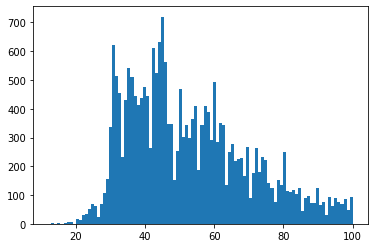

In [20]:
import matplotlib.pyplot as plt
plt.hist(data['total_area'], bins=100, range=(12,100));

**Вывод:**  

Больше всего квартир продаётся с общей площадью от 40 до 69 квадратных метров, максимум предложений приходится на квартиры в 52 квадратных метра

**Жилая площадь**

In [21]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Оставим значения от минимального - 2 квадратных метра до 70 квадратных метров

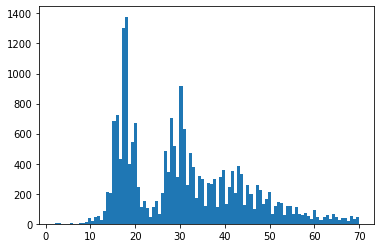

In [22]:
plt.hist(data['living_area'], bins=100, range=(2,70));

По гистограмме видим, что большинство значений сосредоточены в пределах от 15 до 50, исходя из этого построим новую гистограмму

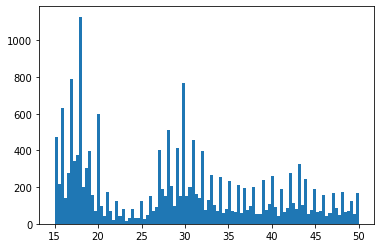

In [23]:
plt.hist(data['living_area'], bins=100, range=(15,50));

**Вывод:**  

Больше всего квартир продаются с жилой площадью около 18 квадратных метров и 30 квадратных метров.По гистограмме видим спад продаж в районе 20-24 квадратных метров

**Площадь кухни**

In [24]:
data['kitchen_area'].describe()

count    23699.000000
mean         9.553814
std          6.420973
min          0.000000
25%          6.300000
50%          9.000000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

Оставим значения от 6 до 12 квадратных метров

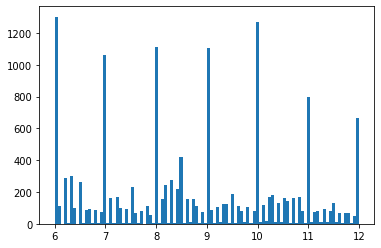

In [25]:
plt.hist(data['kitchen_area'], bins=100, range=(6,12));

**Вывод:**  

По гистограмме видим, что больше всего квартир продаётся с площадью кухни 6 и 10 квадратных метров, так же можно заметить, что на целочисленные значения приходится в разы больше продаж

**Цена объекта**

In [26]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

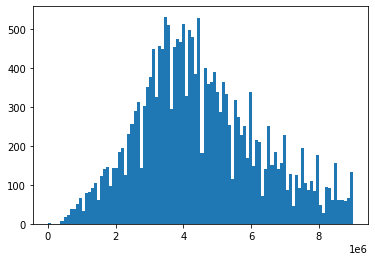

In [27]:
plt.hist(data['last_price'], bins=100, range=(1.219000e+04,9.00000e+06))
plt.show()

**Вывод:** 

По гистограмме видно, что большее количество объявлений приходится на значения от 3,5 млн рублей до 4,5 млн. рублей

**Количество комнат**

In [28]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

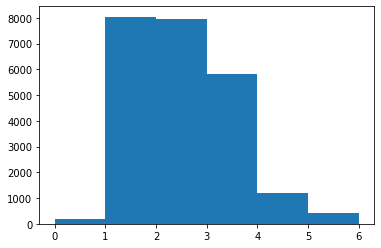

In [29]:
plt.hist(data['rooms'], bins=6, range=(0,6));

**Вывод:**  

По гистограмме видно, что больше всего однокомнатных квартир, а с увеличением количества комнат, количество предложений снижается

**Высота потолков**

In [30]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [31]:
data['ceiling_height'].sort_values(ascending=False).head(50)

22869    100.00
3148      32.00
22336     32.00
21377     27.50
4876      27.00
17857     27.00
5246      27.00
20478     27.00
22938     27.00
5807      27.00
21824     27.00
10773     27.00
5669      26.00
18545     25.00
4643      25.00
9379      25.00
11285     25.00
14382     25.00
355       25.00
6246      25.00
5076      24.00
20507     22.60
17496     20.00
15061     14.00
22309     10.30
5863       8.30
3474       8.00
15743      8.00
17442      8.00
20264      6.00
21227      5.80
1388       5.60
7578       5.50
12628      5.30
1026       5.30
464        5.20
1053       5.00
21923      4.90
2802       4.80
1300       4.70
19142      4.70
12401      4.65
2823       4.50
9783       4.50
10159      4.50
6802       4.50
13224      4.50
14519      4.50
3067       4.50
7521       4.45
Name: ceiling_height, dtype: float64

Заменим явные ошибки - перенесём запятую

In [32]:
data.loc[data['ceiling_height']>=20.0, 'ceiling_height']=data['ceiling_height']/10

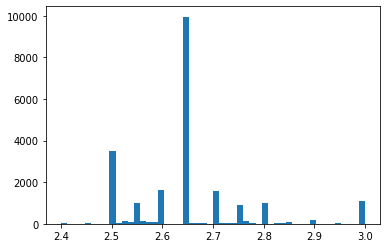

In [33]:
plt.hist(data['ceiling_height'], bins=50, range=(2.4,3));

**Вывод:**  

По гистограмме видим, что большинство предложений с высотой потолков 2,65 метра, затем 2,5 метра, затем в порядке убывания: 2,6 м; 2,7 м; 3,0 м; 2,8 м

**Тип этажа квартиры**

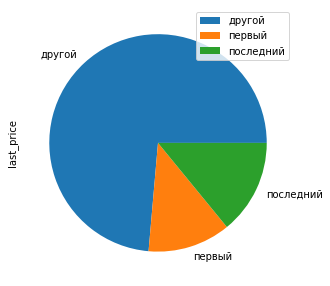

In [34]:
data.pivot_table(index='type_ofapartmentfloor', values='last_price', aggfunc='count').plot.pie(y='last_price', figsize=(5,5));

**Вывод:**  

По круговой диаграмме видим, что чуть больше 25% приходится на продажи квартир на первом и последнем этажах, на основе этого можем сделать вывод о том, что люди хотят съехать с данных этажей

**Общее количество этажей в доме**

In [35]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

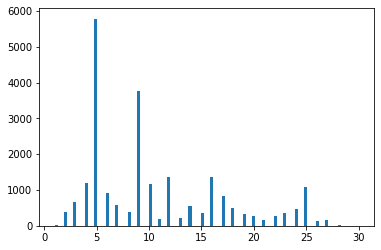

In [36]:
plt.hist(data['floors_total'], bins=100, range=(1,30));

**Вывод:**  

По гистограмме видим, что больше всего продаётся квартир в 5 этажках а на втором месте по количеству объявлений 9 этажки

**Расстояние до центра города в метрах**

In [37]:
data['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

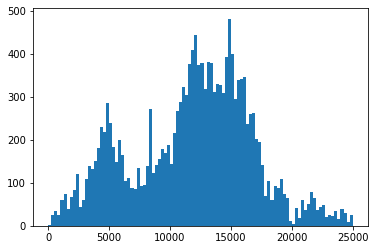

In [38]:
plt.hist(data['cityCenters_nearest'], bins=100, range=(0,25000));

**Вывод:**  Больше всего квартир продаётся на расстоянии 12-15 километров, а так же виден "пик" на удалённости 5 км от центра города

**Расстояние до ближайшего парка**

In [39]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

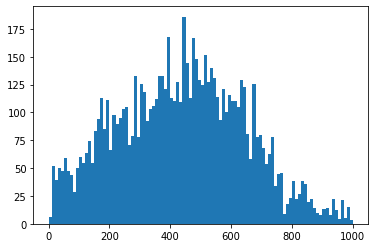

In [40]:
plt.hist(data['parks_nearest'], bins=100, range=(0,1000));

**Вывод:**  

По гистограмме видим, что большинство квартир в объявлениях удалены от парка на 200-700 метров, однако болдьшинство находится на удалении примерно 450 метров

**Общий вывод по разделу:**

1. Больше всего квартир продаётся с общей площадью от 40 до 69 квадратных метров, максимум предложений приходится на квартиры в 52 квадратных метра;
2. Самое большое предложение квартир с жилой площадью около 18 квадратных метров и 30 квадратных метров. Наблюдается спад продаж в районе 20-24 квадратных метров;
3. Из гистограммы следует, что больше всего квартир продаётся с площадью кухни 6 и 10 квадратных метров, так же можно заметить, что на целочисленные значения приходится в разы больше продаж;
4. Большее количество объявлений приходится на значения от 3,5 млн рублей до 4,5 млн. рублей;
5. По гистограмме видно, что больше всего однокомнатных квартир, а с увеличением количества комнат, количество предложений снижается;
6. Большинство предложений с высотой потолков 2,65 метра, затем 2,5 метра, затем в порядке убывания: 2,6 м; 2,7 м; 3,0 м; 2,8 м;
7. По круговой диаграмме видим, что чуть больше 25% приходится на продажи квартир на первом и последнем этажах, на основе этого можем сделать вывод о том, что люди хотят съехать с данных этажей;
8. Больше всего продаётся квартир в 5 этажках а на втором месте по количеству объявлений - 9 этажки;
9. Из гистограммы видим, что больше всего квартир продаётся на расстоянии 12-15 километров, а так же виден "пик" на удалённости 5 км от центра города;
10. Большинство квартир в объявлениях удалены от парка на 200-700 метров, однако преобладают квартиры, находящиеся на удалении примерно 450 метров.


**Изучим, как быстро продавались квартиры**

In [41]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

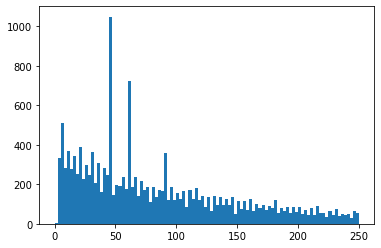

In [42]:
plt.hist(data['days_exposition'],bins=100,range=(0,250));

**Вывод:**

- Среднее значение времени продажи составляет 180 дней, при этом медианное значение составляет 95 дней, что более точно характеризует среднее время продажи, так как на неё не оказывают влияние выбросы. 
- В среднем продажа квартиры занимает 2-3 месяца. 
- Быстрой можно назвать продажу, состоявшуюся до 45 дней с момента публикации объявления (первый квартиль), а долгая продажа - это 232 дня и более с момента публикации (третий квартиль)

**Определим факторы, которые больше всего влияют на общую(полную) стоимость объекта**

Проверим, на сколько коррелируются между собой стоимость объекта и данные параметры (общая площадь, жилая площадь, 
площадь кухни, количество комнат)

In [43]:
data.pivot_table(index='floor', values=['last_price','total_area', 'living_area', 'kitchen_area']).corr()

,kitchen_area,last_price,living_area,total_area
kitchen_area,1.000000,0.284824,0.149369,0.454583
last_price,0.284824,1.000000,0.655849,0.738972
living_area,0.149369,0.655849,1.000000,0.923741
total_area,0.454583,0.738972,0.923741,1.000000


По построенной таблице значений корреляции можем увидеть слабую связь стоимости объекта с общей и жилой площадьми, 
такое может происходить из-за выбросов, попробуем уменьшить их количество

In [44]:
def quartile_scope(data,column):
    q1=data[column].quantile(0.25)
    q3=data[column].quantile(0.75)
    iqr=q3-q1
    right=data.loc[(data[column] < q3+1.5*iqr) & (data[column] > q1-1.5*iqr), column]
    return right
cwo=['last_price','total_area', 'living_area', 'kitchen_area', 'day_ofpublication', 'month_ofpublication', 'year_ofpublication']
for col in cwo:
    data[col]=quartile_scope(data,col)

In [45]:
data.pivot_table(index='floor', values=['last_price','total_area', 'living_area', 'kitchen_area']).corr()

,kitchen_area,last_price,living_area,total_area
kitchen_area,1.000000,0.507438,-0.108534,0.342559
last_price,0.507438,1.000000,0.725857,0.905255
living_area,-0.108534,0.725857,1.000000,0.917353
total_area,0.342559,0.905255,0.917353,1.000000


Уменьшив количество выбросов, получили более явную корреляцию стоимости объекта с общей и жилой площадьми объекта недвижимости.
Построим графики зависимости цены от остальных параметров

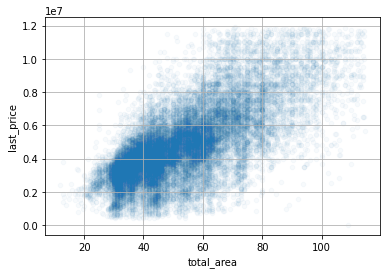

In [46]:
data.plot(x='total_area',y='last_price', kind = 'scatter', alpha=0.03, grid = True);

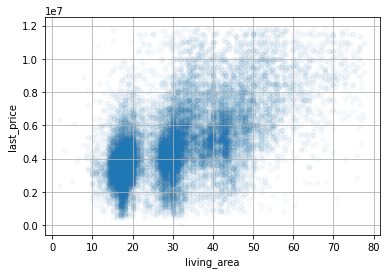

In [47]:
data.plot(x='living_area',y='last_price', kind = 'scatter', alpha=0.03, grid = True);

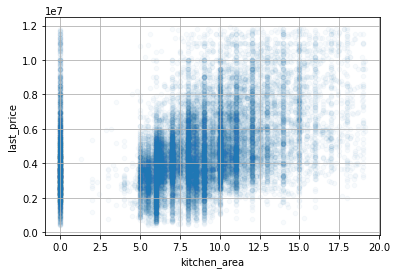

In [48]:
data.plot(x='kitchen_area',y='last_price', kind = 'scatter', alpha=0.03, grid = True);

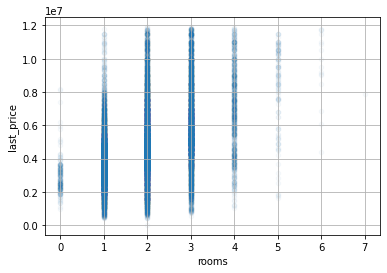

In [49]:
data.plot(x='rooms',y='last_price', kind = 'scatter', alpha=0.03, grid = True);

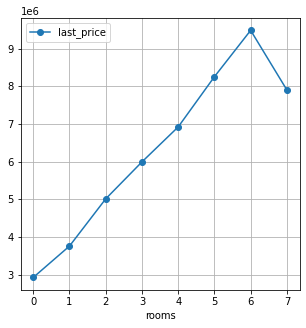

In [50]:
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

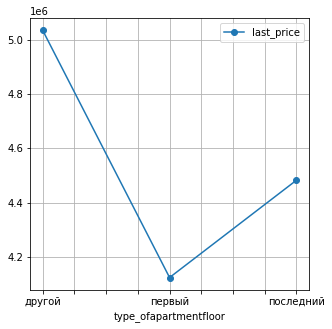

In [51]:
data.pivot_table(index='type_ofapartmentfloor', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

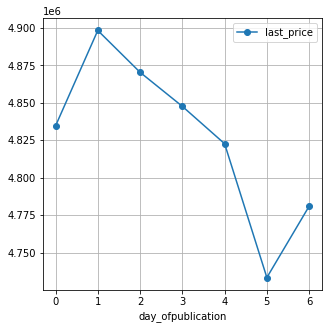

In [52]:
data.pivot_table(index='day_ofpublication', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

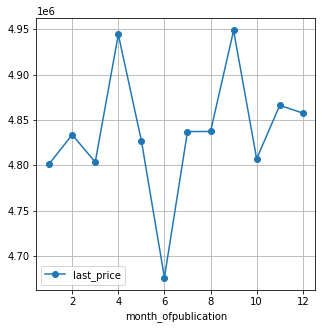

In [53]:
data.pivot_table(index='month_ofpublication', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

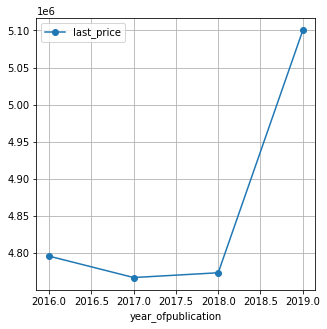

In [54]:
data.pivot_table(index='year_ofpublication', values='last_price').plot(grid=True, style='o-', figsize=(5, 5));

**Вывод:**

- В ходе исследования установили, что больше всего на стоимость влияет общая площадь и жилая площадь квартиры. (Можно сказать, прямая зависимость между величинами)

- Площадь кухни и количество комнат так же оказывают влияние на стоимость, но в меньшей степени - чем больше площадь кухни и количество комнат, тем выше стоимость. 

- Тип этажа так же отражается на стоимости - низкая стоимость у квартир на первом и последнем этажах. 

- Дата размещения не сильно влияет на стоимость, однако можно заметить, что с 2018 года квартиры начали дорожать.

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [55]:
average_price=data.pivot_table(index='locality_name', values='last_price', aggfunc=['count'])
average_price.columns=['count']
average_price=average_price.sort_values(by='count',ascending=False).head(10)
average_price['price_one_meter']=data.pivot_table(index='locality_name', values='price_one_meter').round(2)
average_price.sort_values(by='price_one_meter',ascending=False)

,count,price_one_meter
locality_name,,
санкт-петербург,13737,114849.01
пушкин,338,103125.82
кудрово,470,95324.93
парголово,327,90175.91
мурино,590,86087.51
шушары,440,78677.36
колпино,336,75424.58
гатчина,305,68746.15
всеволожск,397,68654.47


**Вывод:**

Наибольшая средняя стоимость квадратного метра в Санкт-Петербурге и составляет 114849,01 руб. Наименьшая стоимость квадратного метра в городе Выборг и составляет 58141,91 руб.

**Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра**

In [56]:
data.query('locality_name == "санкт-петербург"')['distance_ofcitycntr'].describe()

count    15660.000000
mean        11.596041
std          4.863594
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         29.000000
Name: distance_ofcitycntr, dtype: float64

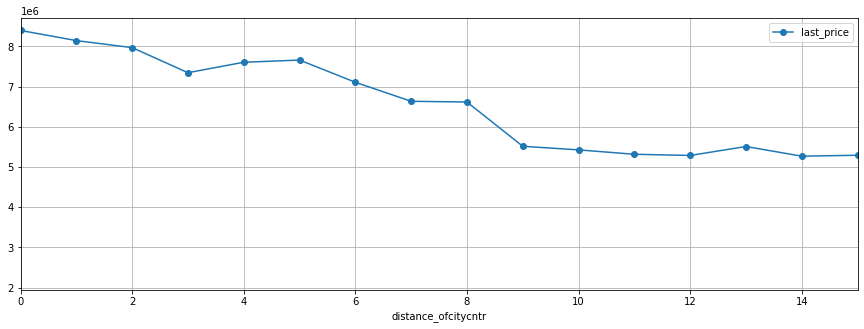

In [57]:
data.query('locality_name == "санкт-петербург"').pivot_table(index='distance_ofcitycntr',values='last_price').plot(grid=True,style='o-',xlim=(0,15), figsize=(15,5));

In [58]:
data.query('locality_name == "санкт-петербург" and distance_ofcitycntr<10').pivot_table(index='distance_ofcitycntr', values='last_price')

,last_price
distance_ofcitycntr,
0.0,8.398000e+06
1.0,8.145277e+06
2.0,7.970519e+06
3.0,7.346575e+06
4.0,7.606618e+06
5.0,7.661225e+06
6.0,7.108234e+06
7.0,6.635321e+06
8.0,6.617244e+06


**Вывод:**

Самые дорогие квартиры в центре города, чем дальше от центра - тем дешевле стоимость. На расстоянии 9 км и более от центра города стоимость квартир перестаёт изменяться в зависимости от удаления от центра города.

### Общий вывод по проекту:

В ходе проведённого исследования было выполнено:

1. Изучили общую информацию по исходным данным:

- Всего в изучаемых данных 23699 строк, присутствуют пропуски и некорректный тип данных, так же по гистограммам можно заметить, что в данных присутствуют аномальные значения.

2. Выполнили предобработку данных, уменьшили количество пропусков в данных, устранили дубликаты. Сделали вывод о том, что основными причинами пропусков могли стать человеческий фактор или несовершенство программного обеспечения.

3. Добавили новые столбцы в исходную таблицу для удобства дальнейшего анализа данных:

- price_one_meter - цена одного квадратного метра;
- day_ofpublication - день недели публикации объявления;
- month_ofpublication - месяц публикации объявления;
- year_ofpublication - год публикации объявления;
- type_ofapartmentfloor - тип этажа квартиры (значения — « первый», «последний», «другой»);
- distance_ofcitycntr - расстояние до центра города в километрах.

4. Провели исследовательский анализ данных, в ходе которого:

4.1 Изучили и описали параметры, установили, что:

- Больше всего квартир продаётся с общей площадью от 40 до 69 квадратных метров, максимум предложений приходится на квартиры в 52 квадратных метра;
- Самое большое предложение квартир с жилой площадью около 18 квадратных метров и 30 квадратных метров. Наблюдается спад продаж в районе 20-24 квадратных метров;
- Из гистограммы следует, что больше всего квартир продаётся с площадью кухни 6 и 10 квадратных метров, так же можно заметить, что на целочисленные значения приходится в разы больше продаж;
- Большее количество объявлений приходится на значения от 3,5 млн рублей до 4,5 млн. рублей;
- По гистограмме видно, что больше всего однокомнатных квартир, а с увеличением количества комнат, количество предложений снижается;
- Большинство предложений с высотой потолков 2,65 метра, затем 2,5 метра, затем в порядке убывания: 2,6 м; 2,7 м; 3,0 м; 2,8 м;
- По круговой диаграмме видим, что чуть больше 25% приходится на продажи квартир на первом и последнем этажах, на основе этого можем сделать вывод о том, что люди хотят съехать с данных этажей;
- Больше всего продаётся квартир в 5 этажках а на втором месте по количеству объявлений - 9 этажки;
- Из гистограммы видим, что больше всего квартир продаётся на расстоянии 12-15 километров, а так же виден "пик" на удалённости 5 км от центра города;
- Большинство квартир в объявлениях удалены от парка на 200-700 метров, однако преобладают квартиры, находящиеся на удалении примерно 450 метров.

4.2 Изучили, как быстро продавались квартиры, а так же установили, что:

- Среднее значение времени продажи составляет 180 дней, при этом медианное значение составляет 95 дней, что более точно характеризует среднее время продажи, так как на неё не оказывают влияние выбросы. 
- В среднем продажа квартиры занимает 2-3 месяца. 
- Быстрой можно назвать продажу, состоявшуюся до 45 дней с момента публикации объявления (первый квартиль), а долгая продажа - это 232 дня и более с момента публикации (третий квартиль)

4.3 Определили факторы, которые больше всего влияют на общую(полную) стоимость объекта:

- В ходе исследования установили, что больше всего на стоимость влияет общая площадь и жилая площадь квартиры. (Можно сказать, прямая зависимость между величинами)

- Площадь кухни и количество комнат так же оказывают влияние на стоимость, но в меньшей степени - чем больше площадь кухни и количество комнат, тем выше стоимость. 

- Тип этажа так же отражается на стоимости - низкая стоимость у квартир на первом и последнем этажах. 

- Дата размещения не сильно влияет на стоимость, однако можно заметить, что с 2018 года квартиры начали дорожать.

4.4 Посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:

- Наибольшая средняя стоимость квадратного метра в Санкт-Петербурге и составляет 114849,01 руб. Наименьшая стоимость квадратного метра в городе Выборг и составляет 58141,91 руб.

4.5 Вычислили среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра:

- Самые дорогие квартиры в центре города, чем дальше от центра - тем дешевле стоимость. На расстоянии 9 км и более от центра города стоимость квартир перестаёт изменяться в зависимости от удаления от центра города.



**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.